In [1]:
# !pip install -q  torch peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 accelerate

import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline
)
from peft import LoraConfig
from trl import SFTTrainer
import matplotlib.pyplot as plt 
import numpy as np 
  

In [2]:
from datasets import load_dataset
from datasets import load_dataset,Features,Value

ds = load_dataset("json",data_files="/home/ac.zyang/LLM/falcon/kbase_formatted_data.json", split='train',field='data')
# ds = ds.select(list(range(50)))
ds = ds.train_test_split(test_size=0.2)

In [3]:
def get_tuning_loss_plot(log_hist, graph_name):
    steps, train_loss, val_loss = [], [], []
    for i in range(len(log_hist)//2):
        steps.append(2*(i+1))
        train_loss.append(log_hist[2*i]['loss'])
        val_loss.append(log_hist[2*i+1]['eval_loss'])

    plt.plot(steps, train_loss, label = "train loss") 
    plt.plot(steps, val_loss, label = "validation loss") 
    plt.legend()
    plt.title("Model fine tune loss")
    plt.xlabel("steps")
    plt.ylabel("loss")
    plt.savefig(f"{graph_name}_tuning_loss.png")
    plt.show()

In [4]:
# Model and tokenizer names
base_model_name = "NousResearch/Llama-2-7b-chat-hf"
refined_model = "llama-2-7b-kbase-4-epochs" #You can give it your own name

# Tokenizer
llama_tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
llama_tokenizer.pad_token = llama_tokenizer.eos_token
llama_tokenizer.padding_side = "right"  # Fix for fp16

# Quantization Config
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False
)

# Model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=quant_config,
    device_map="auto"
)
base_model.config.use_cache = False
base_model.config.pretraining_tp = 1

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ac.zyang/miniconda3/envs/ke/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/ac.zyang/miniconda3/envs/ke/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


/home/ac.zyang/miniconda3/envs/ke/lib/python3.11/site-packages/peft/utils/other.py:122: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/home/ac.zyang/miniconda3/envs/ke/lib/python3.11/site-packages/trl/trainer/sft_trainer.py:166: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/2432 [00:00<?, ? examples/s]

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
10,1.638900,1.700277
20,1.690200,1.490729
30,1.568200,1.354809
40,1.252400,1.347812
50,1.344800,1.302465
60,1.368200,1.276525
70,1.319400,1.266353
80,1.154200,1.267405
90,1.299500,1.243212
100,1.319700,1.227110


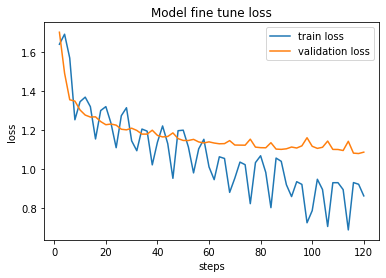

In [5]:
# LoRA Config
peft_parameters = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=8,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "v_proj"]
)

# Training Params
train_params = TrainingArguments(
    output_dir="./results-4-epoches",
    evaluation_strategy = "steps",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=10,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

# Trainer
trainer = SFTTrainer(
    model=base_model,
    train_dataset=ds['train'],
    eval_dataset=ds['test'],
    peft_config=peft_parameters,
    dataset_text_field="text",
    tokenizer=llama_tokenizer,
    args=train_params
)

# Training
trainer.train()

# save model
trainer.save_model(refined_model)

# plot loss graph
get_tuning_loss_plot(trainer.state.log_history, refined_model)